### Load and prepare dataset (containing sentiment)

In [17]:
import pandas as pd

df = pd.read_csv("../data/features_btc_with_synthetic_sentiment.csv", parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# Drop Date and target column from input
X_raw = df.drop(columns=["Date", "Close"])
y = df["Close"].values.reshape(-1, 1)


#### Prepare Feature Sets (with and without sentiment)

In [18]:
from sklearn.preprocessing import MinMaxScaler

feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(X_raw)

target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(y)


#### Scaling + Sequence Generator

In [19]:
import numpy as np

def create_sequences(X, y, window=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
    return np.array(X_seq), np.array(y_seq)

window_size = 10
X, y = create_sequences(X_scaled, y_scaled, window=window_size)


#### Define and Train the LSTM (including sentiment)

In [20]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='tanh', input_shape=(X.shape[1], X.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), verbose=1)


Epoch 1/20


/Users/rahulmansharamani/Desktop/Files/Github/llm-enhanced-btc-predictor/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0148 - val_loss: 0.0053
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1071e-04 - val_loss: 0.0025
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6096e-04 - val_loss: 0.0023
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6510e-04 - val_loss: 0.0020
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2877e-04 - val_loss: 0.0012
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8102e-04 - val_loss: 9.2533e-04
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9205e-04 - val_loss: 9.7570e-04
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0800e-04 - val_loss: 0.0011
Epoch 9/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6845e-04 - val_loss: 9.5172e-04
Epoch 10/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8170e-04 - val_loss: 0.0011
Epoch 11/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5058e-04 - val_loss: 0.0012
Epoch 12/20
90/90 ━━━━━━━━━━━━━━━

#### Evaluate and Compare

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_test_rescaled = target_scaler.inverse_transform(y_test)
y_pred_rescaled = target_scaler.inverse_transform(y_pred)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print("Synthetic Sentiment Model:")
print("RMSE:", round(rmse, 2))
print("MAE:", round(mae, 2))
print("R² Score:", round(r2, 4))


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Synthetic Sentiment Model:
RMSE: 3662.65
MAE: 2884.38
R² Score: 0.9467


#### Plot and Evaluate

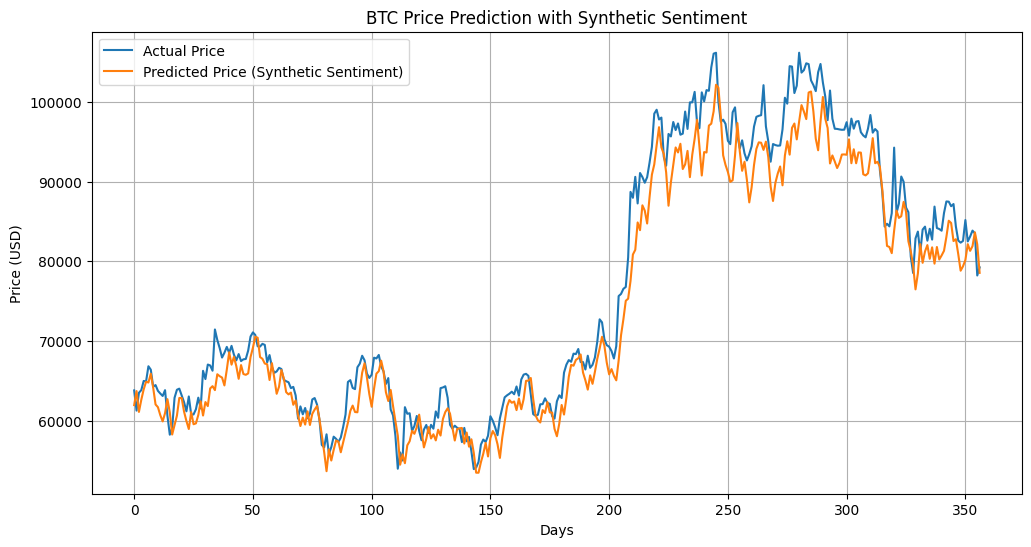

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Price")
plt.plot(y_pred_rescaled, label="Predicted Price (Synthetic Sentiment)")
plt.title("BTC Price Prediction with Synthetic Sentiment")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.show()


In [24]:
import sys
import os

# Add the parent folder (project root) to sys.path
sys.path.append(os.path.abspath(".."))

In [25]:
from src.backtesting_engine import BacktestEngine

In [27]:
# For FinBERT model (on sentiment-aligned subset)
finbert_bt = BacktestEngine(actual=y_test_rescaled.flatten(), predicted=y_pred_rescaled.flatten())
finbert_df = finbert_bt.run()
finbert_bt.summary()

📈 Model Final Portfolio: $959.95
📉 Buy & Hold Portfolio: $1241.70
Delta: $-281.76
Win Rate (buy signal days): 2.81%
